_____
# <p style="text-align: center;">__Customer Churn - Segmentation__<p>
_____

## __Step 1 - Importing Libraries and Dataset__

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches
import plotly.express as px
import os
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
df=pd.read_csv('processed_dataset.csv')

In [3]:
df.head(2)

,id,Churn,Age,Gender,Dependents,Education,Marital_Status,Income_Category,Card_Category,Month_Vintage,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105


## __Step 2 - Segmentation / Demographic__

### _Step 2.1 - Data Preprocessing_

#### _Step 2.1.1 - Sub Dataset_

In [4]:
df.set_index('id',inplace=True)

In [5]:
df.head(2)

,Churn,Age,Gender,Dependents,Education,Marital_Status,Income_Category,Card_Category,Month_Vintage,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
id,,,,,,,,,,,,,,,,,,,,
768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105


In [6]:
# Let's name the demographic data frame as dmg_df
dmg_df=df[['Age','Gender','Dependents','Education','Marital_Status','Income_Category']].copy()
dmg_df.head(1)

,Age,Gender,Dependents,Education,Marital_Status,Income_Category
id,,,,,,
768805383,45,M,3,High School,Married,$60K - $80K


In [7]:
# Checking how many rows ,including unknown variable, the dmg_df have
len(dmg_df.loc[(dmg_df['Education'] == 'Unknown') | (dmg_df['Marital_Status'] == 'Unknown') | 
       (dmg_df['Income_Category'] == 'Unknown')])

3046

In [8]:
# Let's drop those so that we can interpret the results
# more clearly
dmg_df = dmg_df[~dmg_df.isin(['Unknown']).any(axis=1)]
dmg_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7081 entries, 768805383 to 714337233
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Age              7081 non-null   int64 
 1   Gender           7081 non-null   object
 2   Dependents       7081 non-null   int64 
 3   Education        7081 non-null   object
 4   Marital_Status   7081 non-null   object
 5   Income_Category  7081 non-null   object
dtypes: int64(2), object(4)
memory usage: 387.2+ KB


#### _Step 2.1.2 - Label Encoding_

In [9]:
#To perform label encoding, let's use a tool from my toolkit.

def label_encoder(df, columns):

    from sklearn.preprocessing import LabelEncoder
    
    """
    Applies label encoding to multiple columns and returns the encoded DataFrame along with a dictionary
    containing the mapping of label encoding numbers to their corresponding categories.

    Parameters:
    - dataframe: DataFrame to which label encoding will be applied.
    - columns: List of column names where label encoding will be applied.

    Returns:
    - encoded_df: DataFrame with label encoding applied.
    - label_mapping: Dictionary containing label encoding numbers and their corresponding categories.
    """

    encoded_df = df.copy()
    label_mapping = {}

    for col in columns:
        le = LabelEncoder()
        encoded_values = le.fit_transform(encoded_df[col])
        encoded_df[col] = encoded_values

        # Add label encoding mappings to the dictionary
        label_mapping[col] = {label: category for label, category in enumerate(le.classes_)}
    return encoded_df, label_mapping

In [10]:
cols_to_be_encoded=dmg_df.columns.tolist()
cols_to_be_encoded.remove('Dependents')
cols_to_be_encoded.remove('Age')
cols_to_be_encoded

['Gender', 'Education', 'Marital_Status', 'Income_Category']

In [11]:
encoded_dmg_df, label_mapping_dmg = label_encoder(dmg_df, cols_to_be_encoded)
encoded_dmg_df.head(2)

,Age,Gender,Dependents,Education,Marital_Status,Income_Category
id,,,,,,
768805383,45,1,3,3,1,2
818770008,49,0,5,2,2,4


In [12]:
label_mapping_dmg

{'Gender': {0: 'F', 1: 'M'},
 'Education': {0: 'College',
  1: 'Doctorate',
  2: 'Graduate',
  3: 'High School',
  4: 'Post-Graduate',
  5: 'Uneducated'},
 'Marital_Status': {0: 'Divorced', 1: 'Married', 2: 'Single'},
 'Income_Category': {0: '$120K +',
  1: '$40K - $60K',
  2: '$60K - $80K',
  3: '$80K - $120K',
  4: 'Less than $40K'}}

#### _Step 2.1.3 - Scaling_

In [13]:
#Scaling before Dimensionality Reduction. For Scaling let's use a function 
#from my toolkit

def Scaler(df,to_be_scaled,t="n"):
    
    '''
    Scaler works with:
    df: should be type of pandas.core.frame.DataFrame
    to_be_encoded: should be type of either of the following ["pandas.core.indexes.base.Index","list","tuple"]
    '''

    # Input variable checks & errors

    wrong_column_name=[]

    if isinstance(df, pd.core.frame.DataFrame)==False:
        print("The first variable is not a pandas data frame, please enter a pandas data frame")
        return
    
    if len(df)==0:
        print("The data frame is empty, please check your data frame.")
        return
    
    if len(to_be_scaled)==0:
        print("The list of columns, to be scaled, is empty. Please check your list.")
        return
    
    for i in to_be_scaled:
        if i not in df.columns.tolist():
            wrong_column_name.append(i)
    
    if len(wrong_column_name)>0:
        if len(wrong_column_name)==1:
            print("There is no such a column as: {}".format(wrong_column_name))
        if len(wrong_column_name)>1:
            print("There are no columns as: {}".format(wrong_column_name))
        return
    
    if t.lower()!="n" and t.lower()!="s" and t.lower()!="rs":
        print("Please put the third input as N, S or RS for Normalization, Standardization and Robust Scaler respectively")
        return

    # Importing necessary models
    
    from sklearn.preprocessing import StandardScaler
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.preprocessing import RobustScaler

    # Scaling
    
    new_df=df.copy()

    if t.lower()=="n":
        model=MinMaxScaler()
        for i in to_be_scaled:
            new_df[i]=model.fit_transform(new_df[[i]])
        print("Normalized df is prepared")
    
    elif t.lower()=="rs":
        model=RobustScaler()
        for i in to_be_scaled:
            new_df[i]=model.fit_transform(new_df[[i]])
        print("Robust Scaled df is prepared")

    else:
        model=StandardScaler()
        for i in to_be_scaled:
            new_df[i]=model.fit_transform(new_df[[i]])
        print("Standardized df is prepared")

    return new_df



In [14]:
cols_to_be_scaled=dmg_df.columns.tolist()
cols_to_be_scaled

['Age',
 'Gender',
 'Dependents',
 'Education',
 'Marital_Status',
 'Income_Category']

In [15]:
scaled_encoded_dmg_df=Scaler(encoded_dmg_df,cols_to_be_scaled,'s')
scaled_encoded_dmg_df.head(2)

Standardized df is prepared


,Age,Gender,Dependents,Education,Marital_Status,Income_Category
id,,,,,,
768805383,-0.167610,0.954298,0.512710,0.285484,-0.542306,-0.431950
818770008,0.329862,-1.047890,2.061228,-0.388353,1.071846,1.014215


#### _Step 2.1.4 - PCA_

In [16]:
#PCA
pca = PCA(n_components=3)
pca.fit(scaled_encoded_dmg_df)

PCA(n_components=3)

In [17]:
dims=pd.DataFrame(pca.transform(scaled_encoded_dmg_df),columns=['D1','D2','D3']).set_index(scaled_encoded_dmg_df.index)
dims.head(2)

,D1,D2,D3
id,,,
768805383,1.039779,-0.499126,-0.192965
818770008,-1.357487,-1.121941,0.212260


### _Step 2.2 - Clustering_

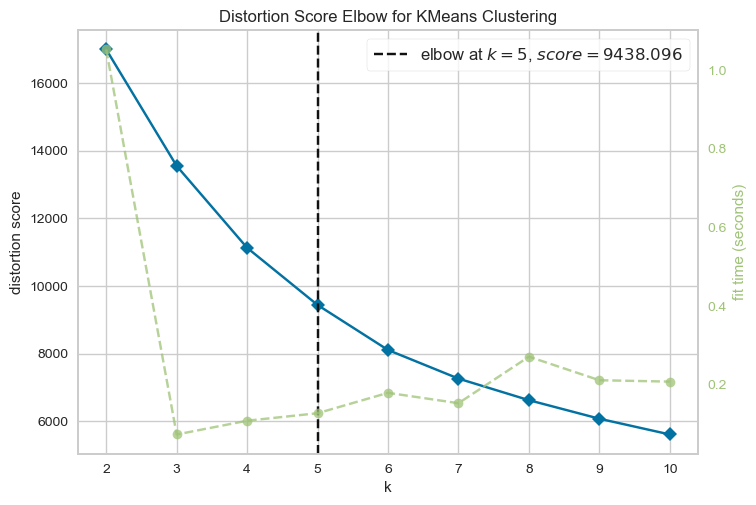

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [18]:
#Let's calculate how many clusters will be more effective (up to 10)

model=KElbowVisualizer(KMeans(),k=10)
model.fit(dims)
model.show()

In [19]:
# After number 5, the decrease in the steps of cluster number increasing declines
# We will continue with 5 clusters

cluster_model=KMeans(n_clusters=5)
cluster_model.fit(scaled_encoded_dmg_df)
segments=cluster_model.predict(scaled_encoded_dmg_df)
dims['Segment']=segments
dims.head(2)

,D1,D2,D3,Segment
id,,,,
768805383,1.039779,-0.499126,-0.192965,2
818770008,-1.357487,-1.121941,0.212260,0


In [20]:
plt.figure(figsize=(12,12))

custom_palette = ["#F0810F", "#063852", "#E6DF44", "#800080", "#45AAB8" ]

fig = px.scatter_3d(dims, x='D1', y='D2', z='D3',
              color='Segment',color_discrete_sequence=custom_palette, opacity=0.8, symbol = 'Segment')

# Adjust the size of the data points
fig.update_traces(marker=dict(size=2))

fig.update_layout(title="Plot of Clusters", height=600, width=800)
fig.show()

<Figure size 1200x1200 with 0 Axes>

### _Step 2.3 - Interpretation_

In [21]:
dmg_df['Segment']=segments
dmg_df.head(2)

,Age,Gender,Dependents,Education,Marital_Status,Income_Category,Segment
id,,,,,,,
768805383,45,M,3,High School,Married,$60K - $80K,2
818770008,49,F,5,Graduate,Single,Less than $40K,0


In [22]:
sns.set_style('whitegrid')

In [23]:
def categorical_plot(df, cat_cols, num_cols_per_row=None, hue=None):
    """
    Plots the distribution of categorical columns in a pandas DataFrame.

    Parameters:
    ----------
    df : pandas.DataFrame
        The DataFrame containing the categorical columns to be plotted.
    cat_cols : list of str
        A list of column names that contain categorical data.
    num_cols_per_row : int
        The number of columns to plot per row.
    hue : str or None, optional
        If not None, specifies the hue cycle to use for the plots.
            Otherwise, uses a default cycle.
    """
    if num_cols_per_row is None:
        num_cols_per_row = 2
    
    num_rows = len(cat_cols) // num_cols_per_row + 1

    fig, axes = plt.subplots(num_rows, num_cols_per_row, figsize=(20, 20))

    if hue is None:
        # Use a default hue cycle when hue is not given
        for i, col in enumerate(cat_cols):
            row_index = i // num_cols_per_row
            col_index = i % num_cols_per_row
            
            ax = axes[row_index, col_index]
            order = df[col].value_counts().index
            sns.countplot(data=df, x=col, ax=ax, hue=col, order=order)
            ax.set_title(col)

            total = len(df[col])
            for p in ax.patches:
                percentage = '{:.1f}%'.format(100 * p.get_height() / total)
                x = p.get_x() + p.get_width() / 2
                y = p.get_height()
                ax.annotate(percentage, (x, y), ha='center', va='bottom')

            ax.set_xlabel('')

    else:
        # Use the given hue cycle when hue is given
        for i, col in enumerate(cat_cols):
            row_index = i // num_cols_per_row
            col_index = i % num_cols_per_row
            
            ax = axes[row_index, col_index]
            order = df[col].value_counts().index
            sns.countplot(data=df, x=col, ax=ax, hue=hue, order=order,palette='deep')
            ax.set_title(col)

            total = len(df[col])
            for p in ax.patches:
                percentage = '{:.1f}%'.format(100 * p.get_height() / total)
                x = p.get_x() + p.get_width() / 2
                y = p.get_height()
                ax.annotate(percentage, (x, y), ha='center', va='bottom')

            ax.set_xlabel('')

    # Deleting the empty graph placeholders
    for i in range(len(cat_cols), num_rows * num_cols_per_row):
        fig.delaxes(axes.flatten()[i])
    
    plt.tight_layout()
    plt.show()

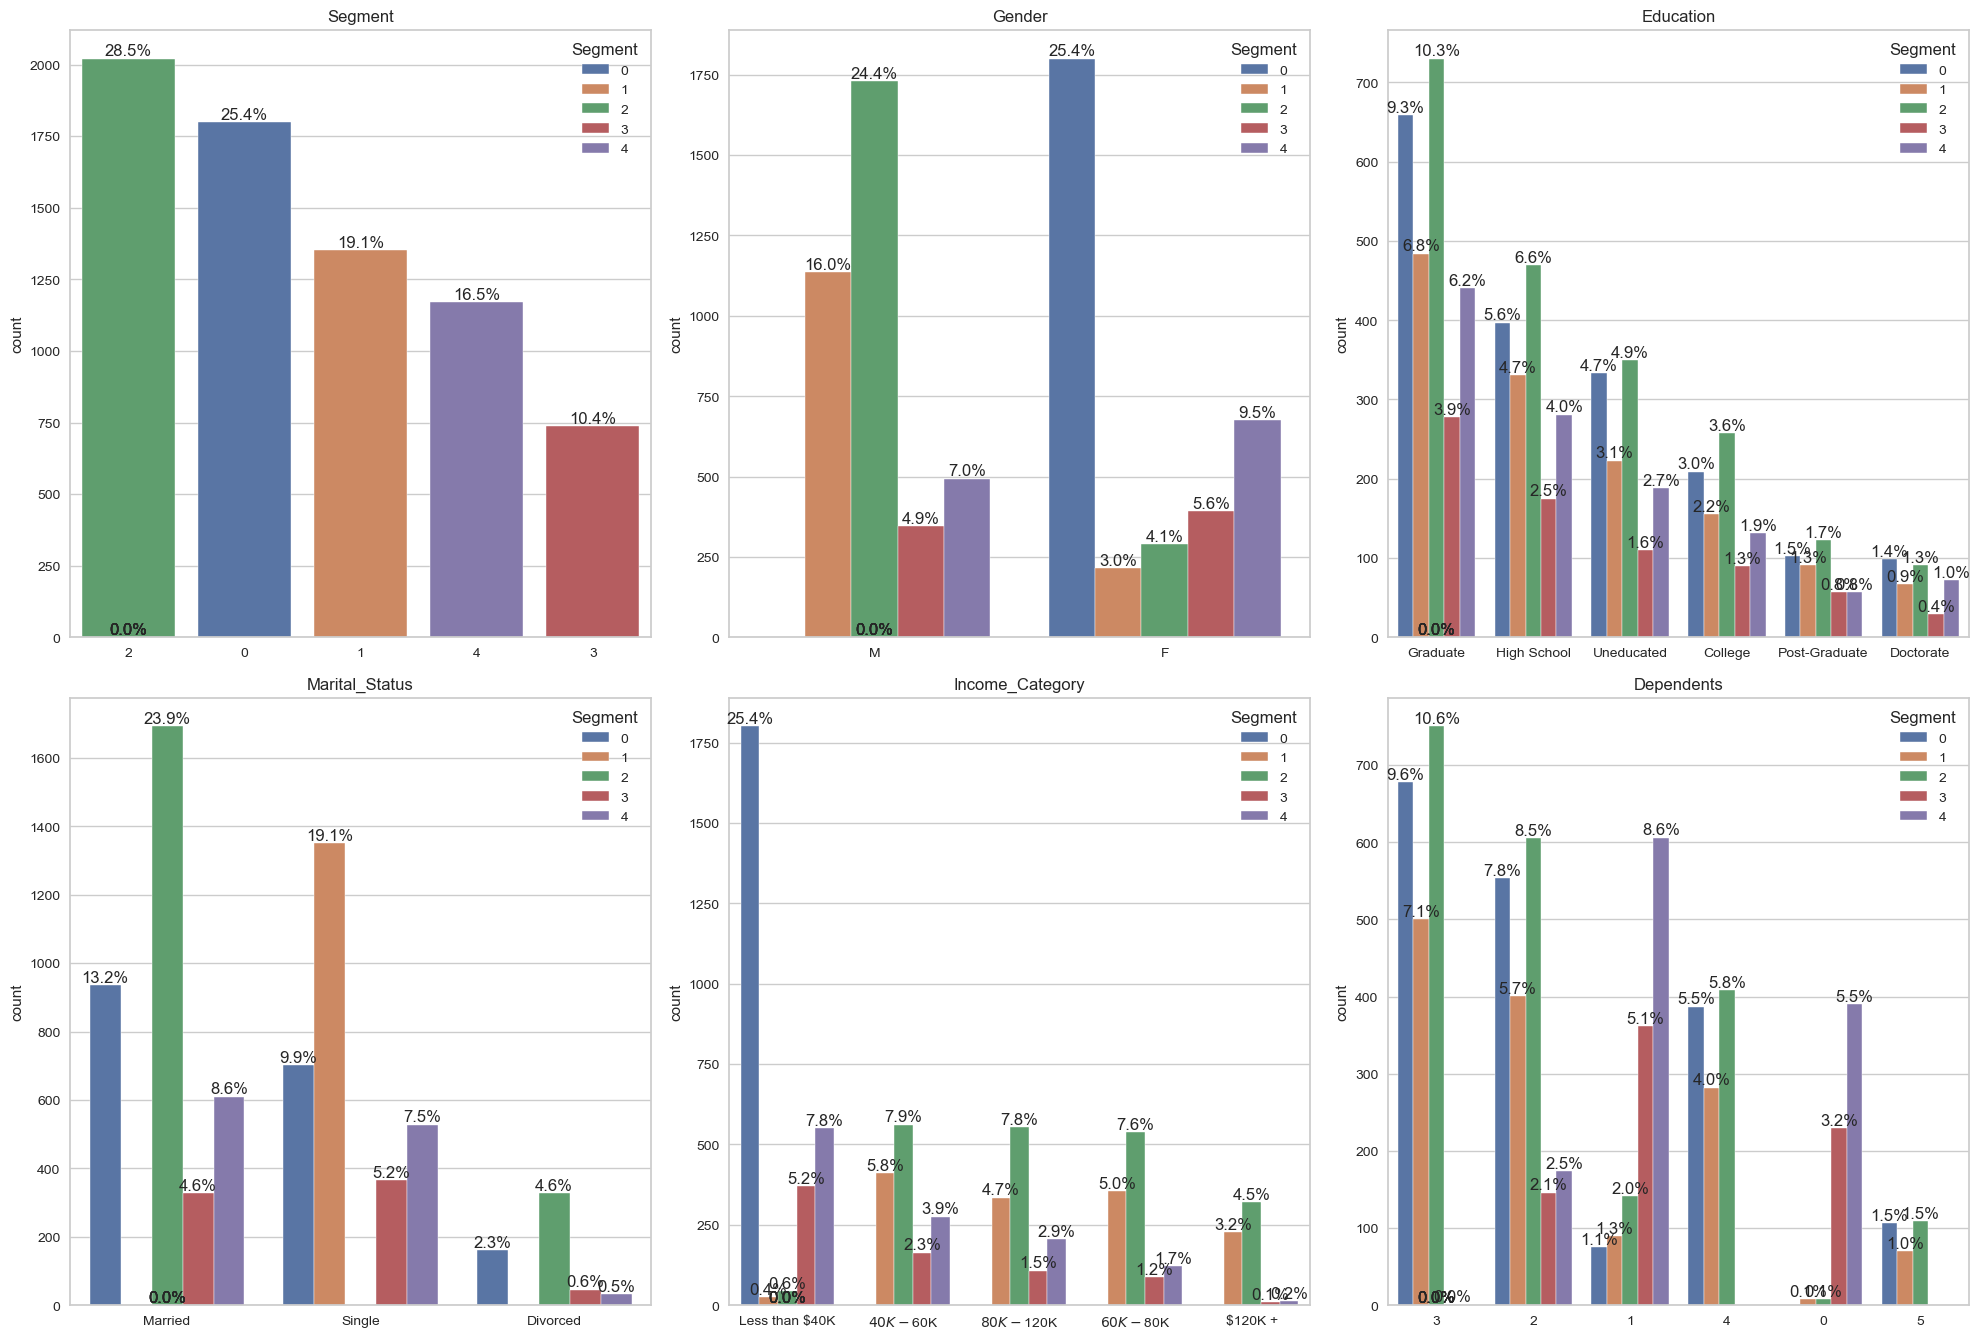

In [24]:
categorical_plot(dmg_df,['Segment','Gender','Education','Marital_Status','Income_Category','Dependents'],3,hue='Segment')

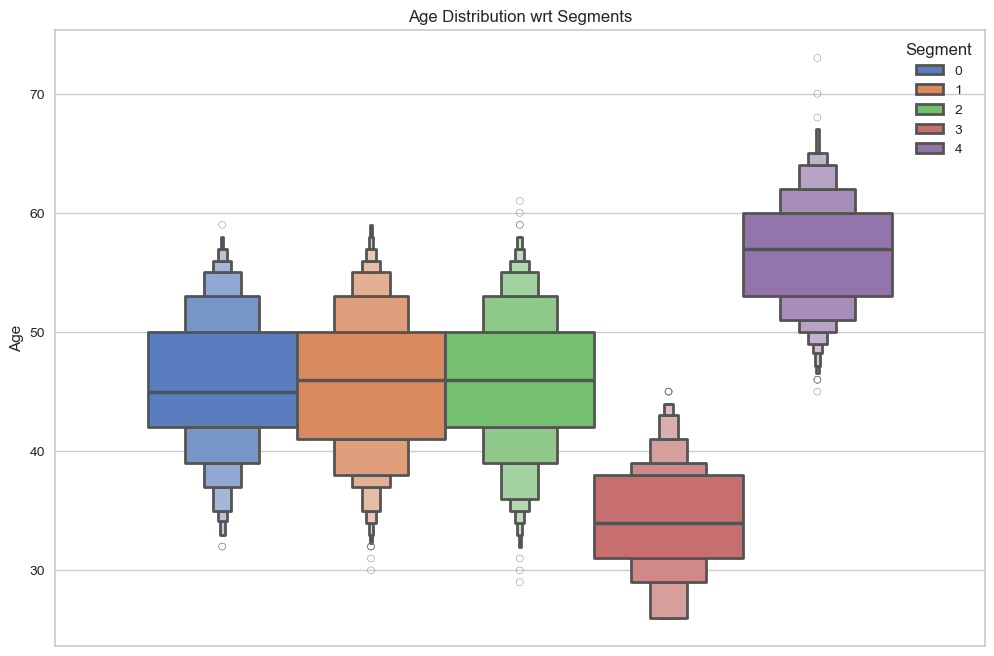

In [44]:
plt.figure(figsize=(12,8))
sns.boxenplot(data=dmg_df,y='Age',hue='Segment',palette='muted',linewidth=2)
plt.title('Age Distribution wrt Segments')
plt.savefig(os.path.join("Images","Age wrt Segments"))
plt.show()

Differentiating Segment Characteristics

Segment0
- Approximately 98% Female 
- Mostly Married
- Most of them earn below 40K

Segment1
- Approximately 85% Male
- Mostly Single
- Balanced earning btw 40-120K

Segment2
- Approximately 98% Female
- Approximately 78% Single
- Most of them earn below 40K

Segment3
- Approximately 80% Male
- Married(85%) or Divorced (15%)
- Balanced earning btw 40-120K
- Biggest segment
- Their age average is remarkably below from the whole average

Segment4
- Smallest segment
- Their age average is remarkably above from the average

## __Step 3 - Segmentation / Spending Behavior__

### _Step 3.1 - Data Preprocessing_

#### _Step 3.1.1 - Sub Dataset_

In [26]:
# Let's name the Spending Behavior data frame as s_b_df
s_b_df=df.drop(columns=['Age','Gender','Dependents','Education','Marital_Status','Income_Category','Churn']).copy()
s_b_df.head(2)

,Card_Category,Month_Vintage,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
id,,,,,,,,,,,,,
768805383,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
818770008,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105


#### _Step 3.1.2 - Label Encoding_

In [27]:
encoded_s_b_df, label_mapping_s_b = label_encoder(s_b_df, ['Card_Category'])
encoded_s_b_df.head(2)

,Card_Category,Month_Vintage,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
id,,,,,,,,,,,,,
768805383,0,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
818770008,0,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105


#### _Step 3.1.3 - Scaling_

In [28]:
#Scaling
scaled_encoded_s_b_df=Scaler(encoded_s_b_df,encoded_s_b_df.columns.tolist(),'s')
scaled_encoded_s_b_df.head(2)

Standardized df is prepared


,Card_Category,Month_Vintage,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
id,,,,,,,,,,,,,
768805383,-0.259473,0.384621,0.763943,-1.327136,0.492404,0.446622,-0.473422,0.488971,2.623494,-0.959707,-0.973895,3.834003,-0.775882
818770008,-0.259473,1.010715,1.407306,-1.327136,-0.411616,-0.041367,-0.366667,-0.008486,3.563293,-0.916433,-1.357340,12.608573,-0.616276


#### _Step 3.1.4 - PCA_

In [29]:
#PCA
pca = PCA(n_components=3)
pca.fit(scaled_encoded_s_b_df)

PCA(n_components=3)

In [30]:
dims_s_b=pd.DataFrame(pca.transform(scaled_encoded_s_b_df),columns=['D1','D2','D3']).set_index(scaled_encoded_s_b_df.index)
dims_s_b.head(2)

,D1,D2,D3
id,,,
768805383,0.201800,-0.616614,3.515479
818770008,-0.599553,1.424640,8.113083


### _Step 3.2 - Clustering_

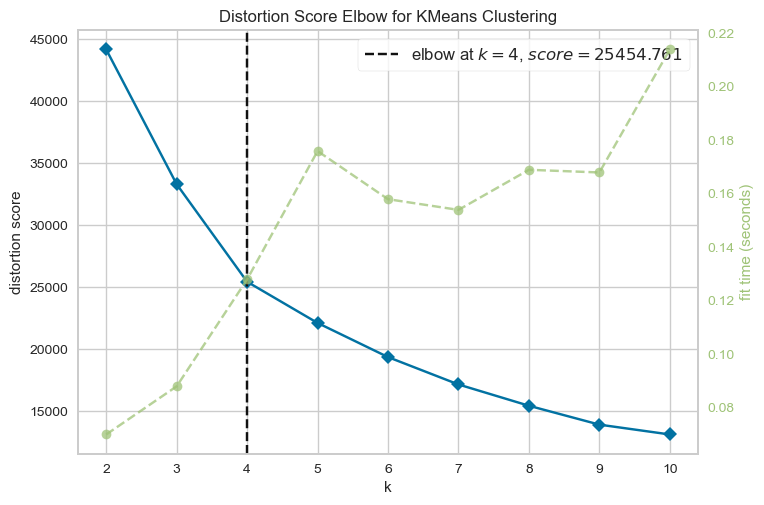

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [31]:
#Let's calculate how many clusters will be more effective (up to 10)

model=KElbowVisualizer(KMeans(),k=10)
model.fit(dims_s_b)
model.show()

In [32]:
# After number 4, the decrease in the steps of cluster number increasing declines
# We will continue with 4 clusters for the spending behavior segmentation

cluster_model=KMeans(n_clusters=4)
cluster_model.fit(scaled_encoded_s_b_df)
segments_s_b=cluster_model.predict(scaled_encoded_s_b_df)
dims_s_b['Segment']=segments_s_b
dims_s_b.head(2)

,D1,D2,D3,Segment
id,,,,
768805383,0.201800,-0.616614,3.515479,1
818770008,-0.599553,1.424640,8.113083,0


### _Step 3.3 - Interpretation_

In [33]:
plt.figure(figsize=(12,12))

custom_palette = ["#F0810F", "#063852", "#E6DF44", "#800080"]

fig = px.scatter_3d(dims_s_b, x='D1', y='D2', z='D3',
              color='Segment',color_discrete_sequence=custom_palette, opacity=0.8, symbol = 'Segment')

# Adjust the size of the data points
fig.update_traces(marker=dict(size=2))

fig.update_layout(title="Plot of Clusters", height=600, width=800)
fig.show()

<Figure size 1200x1200 with 0 Axes>

In [36]:
s_b_df['Segment']=segments_s_b
s_b_df.head(2)

,Card_Category,Month_Vintage,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Segment
id,,,,,,,,,,,,,,
768805383,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,1
818770008,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0


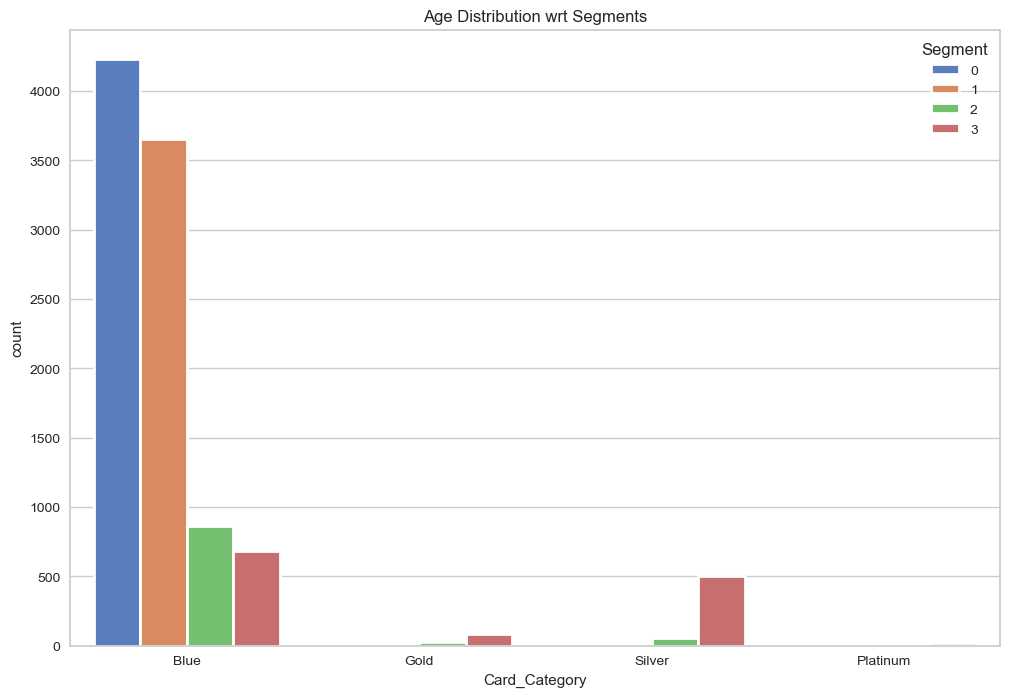

In [42]:
plt.figure(figsize=(12,8))
sns.countplot(data=s_b_df,x='Card_Category',hue='Segment',palette='muted',linewidth=2)
plt.title('Age Distribution wrt Segments')
plt.show()